In [2]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, Template, ExtendedBinnedNLL
import numpy as np
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict
from joblib import Parallel, delayed

In [3]:
def generate(rng, nmc, truth, bins):
    xe = np.linspace(0, 2, bins + 1)
    b = np.diff(truncexpon(1, 0, 2).cdf(xe))
    s = np.diff(norm(1, 0.1).cdf(xe))
    n = rng.poisson(b * truth[0]) + rng.poisson(s * truth[1])
    t = np.array([rng.poisson(b * nmc), rng.poisson(s * nmc)])
    return xe, n, t

rng = np.random.default_rng(1)
n_data = 1000
truth = np.round(n_data*0.75), np.round(n_data*0.25)
xe, n, t = generate(rng, 100, truth, 15)

In [4]:
print(xe)
print(n)
print(t)

[0.         0.13333333 0.26666667 0.4        0.53333333 0.66666667
 0.8        0.93333333 1.06666667 1.2        1.33333333 1.46666667
 1.6        1.73333333 1.86666667 2.        ]
[ 77  67  76  64  65  58 112 144  95  49  40  37  36  34  29]
[[ 6 11  7  4 12  5  9  4 10  4  7  5  7  6  0]
 [ 0  0  0  0  0  2 19 52 25  1  0  0  0  0  0]]


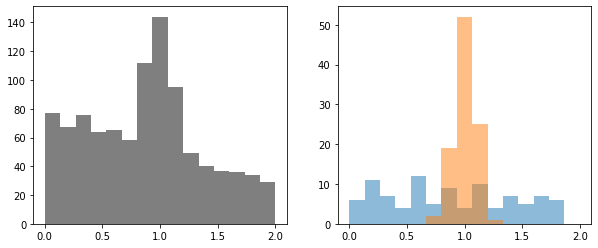

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].stairs(n, xe, fill=True, color="k", alpha=0.5, label="data")
for i, ti in enumerate(t):
    ax[1].stairs(ti, xe, fill=True, alpha=0.5, label=f"template {i}")

In [106]:
class BB:
    def __init__(self, xe, n, t):
        self.xe = xe
        self.data = n, t

    def _pred(self, par):
        bins = len(self.xe) - 1
        yields = par[:2]
        nuisances = np.array(par[2:])
        b = nuisances[:bins]
        s = nuisances[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * np.array(c) / np.sum(c)
        return mu, b, s

    def __call__(self, par):
        n, t = self.data
        mu, b, s = self._pred(par)
        r = poisson_chi2(n, mu) + poisson_chi2(t[0], b) + poisson_chi2(t[1], s)
        return r

    @property
    def ndata(self):
        n, t = self.data
        return np.prod(n.shape) + np.prod(t.shape)

    def visualize(self, args):
        n, t = self.data
        ne = n ** 0.5
        xe = self.xe
        cx = 0.5 * (xe[1:] + xe[:-1])
        plt.errorbar(cx, n, ne, fmt="ok")
        mu = 0
        mu_var = 0
        for y, c in zip(args[:2], t):
            f = 1 / np.sum(c)
            mu += c * y * f
            mu_var += c * (f * y) ** 2
        mu_err = mu_var ** 0.5
        plt.stairs(mu + mu_err, xe, baseline=mu - mu_err, fill=True, color="C0")
        # plt.stairs(mu, xe, color="C0")

In [107]:
m1 = Minuit(BB(xe, n, t), np.concatenate([truth, t[0], t[1]]))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.27 (χ²/ndof = 1.4)      │             Nfcn = 3412              │
│ EDM = 1.3e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    800    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
│ 2 │ x2   │    9.0    │    1.4    │            │            │    0    │         │       │
│ 3 │ x3   │    8.5    │    1.3    │            │            │    0    │         │       │
│ 4 │ x4   │    9.0    │    1.4    │            │            │    0    │         │       │
│ 5 │ x5   │    7.4    │    1.2    │            │            │    0    │         │       │
│ 6 │ x6   │    8.4    │    1.3    │            │            │    0    │         │       │
│ 7 │ x7   │    6.4    │    1.1    │            │            │    0    │         │       │
│ 8 │ x8   │    9.2    │    1.7    │            │            │    0    │         │       │
│ 9 │ x9   │    4.8    │    2.3    │            │            │    0    │         │       │
│ 10│ x10  │    7.0    │    1.5    │            │            │    0    │         │       │
│ 11│ x11  │    5.5    │    1.0    │            │            │    0    │         │       │
│ 12│ x12  │    5.1    │    0.9    │            │            │    0    │         │       │
│ 13│ x13  │    4.6    │    0.9    │            │            │    0    │         │       │
│ 14│ x14  │    4.7    │    0.9    │            │            │    0    │         │       │
│ 15│ x15  │    4.3    │    0.8    │            │            │    0    │         │       │
│ 16│ x16  │    3.2    │    0.7    │            │            │    0    │         │       │
│ 17│ x17  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 18│ x18  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 19│ x19  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 20│ x20  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 21│ x21  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 22│ x22  │    2.1    │    1.5    │            │            │    0    │         │       │
│ 23│ x23  │    19     │     4     │            │            │    0    │         │       │
│ 24│ x24  │    54     │     7     │            │            │    0    │         │       │
│ 25│ x25  │    23     │     4     │            │            │    0    │         │       │
│ 26│ x26  │    1.1    │    1.0    │            │            │    0    │         │       │
│ 27│ x27  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 28│ x28  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 29│ x29  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 30│ x30  │    0.0    │    0.4    │            │            │    0    │         │   

In [108]:
c = Template(n, xe, t, method="jsc") # Conway
m2 = Minuit(c, *truth)
m2.limits = (0, None)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.52 (χ²/ndof = 0.9)      │              Nfcn = 48               │
│ EDM = 6.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.86e3   │  0.11e3   │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 1.16e+04   -1.6e3 │
│ x1 │   -1.6e3 1.94e+03 │
└────┴───────────────────┘

In [109]:
c = Template(n, xe, t, method="da") # Dembinski, Abdelmotteleb
m3 = Minuit(c, *truth)
m3.limits = (0, None)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.42 (χ²/ndof = 0.9)      │              Nfcn = 47               │
│ EDM = 1.85e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    760    │    90     │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 8.08e+03   -1.3e3 │
│ x1 │   -1.3e3 1.81e+03 │
└────┴───────────────────┘

In [110]:
for title, m in zip(("full fit", "T(JSC)", "T(DA)"), (m1, m2, m3)):
    print(title)
    cov = m.covariance
    for label, p, e in zip(("x0", "x1"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / (cov[0, 0] * cov[1, 1]) ** 0.5:.2f}")

full fit
  x0 796 +- 47
  x1 187 +- 40
  correlation -0.76
T(JSC)
  x0 858 +- 108
  x1 185 +- 44
  correlation -0.33
T(DA)
  x0 762 +- 90
  x1 194 +- 43
  correlation -0.33


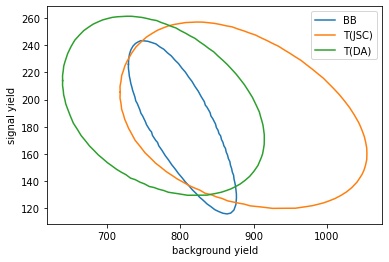

In [111]:
c1 = m1.mncontour("x0", "x1")
c2 = m2.mncontour("x0", "x1")
c3 = m3.mncontour("x0", "x1")
plt.plot(c1[:,0], c1[:, 1], label="BB")
plt.plot(c2[:,0], c2[:, 1], label="T(JSC)")
plt.plot(c3[:,0], c3[:, 1], label="T(DA)")
plt.xlabel("background yield")
plt.ylabel("signal yield")
plt.legend();